# Introduction

We first load [DrWatson](https://juliadynamics.github.io/DrWatson.jl/dev/),
a scientific project management software that helps reproducibility.

In [1]:
using DrWatson

We then activate this project, which also loads a bundle of packages
(most notably ClimateBase.jl), and includes all files in the `src` folder.

In [2]:
@quickactivate :AlbedoProperties

We then load the style file for the figures (text size, colors, etc.)

In [3]:
include(srcdir("plotting", "advanced.jl"))
include(papersdir("paperstyle.jl"))

Load all necessary CERES files explicitly

In [4]:
EBAF_TOA = datadir("CERES", "EBAF_TOA.nc")
EBAF_SFC = datadir("CERES", "EBAF_SFC.nc")
SEAICE = datadir("CERES", "SYN1deg_AUX.nc")

"C:\\Users\\datse\\ownCloud\\Projects\\AlbedoProperties\\data\\CERES\\SYN1deg_AUX.nc"

And from these files load all spatiotemporal fields necessary

In [5]:
R = ncread(EBAF_TOA, "toa_sw_all_mon")
K = ncread(EBAF_TOA, "toa_sw_clr_c_mon")
I = ncread(EBAF_TOA, "solar_mon")
F = ncread(EBAF_TOA, "cldarea_total_daynight_mon") ./ 100
T = ncread(EBAF_TOA, "cldtau_total_day_mon")
O = ncread(SEAICE, "aux_ocean_mon") ./ 100
E = ncread(SEAICE, "aux_snow_mon") ./ 100
L = clamp.(1 .- O .- E, 0, 1) # ice-free land
R

ClimArray (named toa_sw_all_mon) with dimensions:
  Lon (Longitude): 0.5f0:1.0f0:359.5f0 (Sampled - Ordered Regular Points)
  Lat (Latitude): -89.5f0:1.0f0:89.5f0 (Sampled - Ordered Regular Points)
  Ti (Time): Date("2000-03-15"):Month(1):Date("2020-04-15") (Sampled - Ordered Regular Points)
attributes: Dict{String, Any} with 8 entries:
  "units"         => "W m-2"
  "CF_name"       => "toa_outgoing_shortwave_flux"
  "long_name"     => "Top of The Atmosphere Shortwave Flux, All-Sky conditions,…
  "standard_name" => "TOA Shortwave Flux - All-Sky"
  "valid_min"     => "      0.00000"
  "_FillValue"    => -999.0
  "comment"       => "none"
  "valid_max"     => "      600.000"
and data: 360×180×242 Array{Float32, 3}
[:, :, 1]
 43.85  43.66  44.45  45.77  49.29  …  22.4  20.48  18.44  16.94  17.78
 43.85  43.66  44.45  45.77  49.29     22.4  20.48  18.44  16.94  17.78
 43.85  43.66  44.45  45.77  49.29     22.4  20.48  18.44  16.94  17.78
  ⋮                                 ⋱   ⋮           

The time vector is

In [6]:
t = dims(R, Time).val

Date("2000-03-15"):Month(1):Date("2020-04-15")

and the month counter is

In [7]:
tn = 1:length(t)

1:242

And the following index is the most amount of data we can use for full-years

In [8]:
mys = maxyearspan(t)

240

Notice that not all CERES data have this time span. Surface fluxes and ice fractions
cover less amount of time, thus for operations involving this data we will infact be
forced to use a smaller time span.

Time in cumulative number of days per month is

In [9]:
truetime = daysinmonth.(t)
truetime = Float32.(cumsum(truetime))

242-element Vector{Float32}:
   31.0
   61.0
   92.0
  122.0
  153.0
  184.0
  214.0
  245.0
  275.0
  306.0
  337.0
  365.0
  396.0
    ⋮
 7031.0
 7061.0
 7092.0
 7123.0
 7153.0
 7184.0
 7214.0
 7245.0
 7276.0
 7305.0
 7336.0
 7366.0

Ιn most figures we will be showing a sub-set of the total time (purely for visual clarity,
and actual span chosen below is completely arbitrary)

In [10]:
tspan = (Date(2008), Date(2015))

(Date("2008-01-01"), Date("2015-01-01"))

This is how we decompose
some fields into northern-southern hemisphere average timeseries.

In [11]:
Ιn, Is = hemispheric_means(I)
Rn, Rs = hemispheric_means(R)
Rn

ClimArray with dimensions:
  Ti (Time): Date("2000-03-15"):Month(1):Date("2020-04-15") (Sampled - Ordered Regular Points)
and data: 242-element Vector{Float32}
Float32[96.3623, 118.143, 136.228, 139.427, 132.015, 118.122, 99.5351, 83.2414, 68.202, 61.3621  …  130.633, 116.746, 97.4008, 79.9835, 67.7827, 60.4773, 64.5694, 76.166, 95.932, 116.549]

This is a good point to demonstrate how critical it is for one to do proper temporal
averaging. Integrated over a full yearly cycle, both hemispheres receive
the same amount of insolation. This is a direct consequence of Kepler's second law.

In [12]:
timemean(Ιn) - timemean(Is)

-0.002882371676605544

Using a standard mean instead, while still only including full years, gives

In [13]:
mean(Ιn[1:mys]) - mean(Is[1:mys])

-0.63327026f0

which is a clear violation of Kepler's second law.

# Timeseries analysis of reflected solar rad.

## Seasonal decomposition

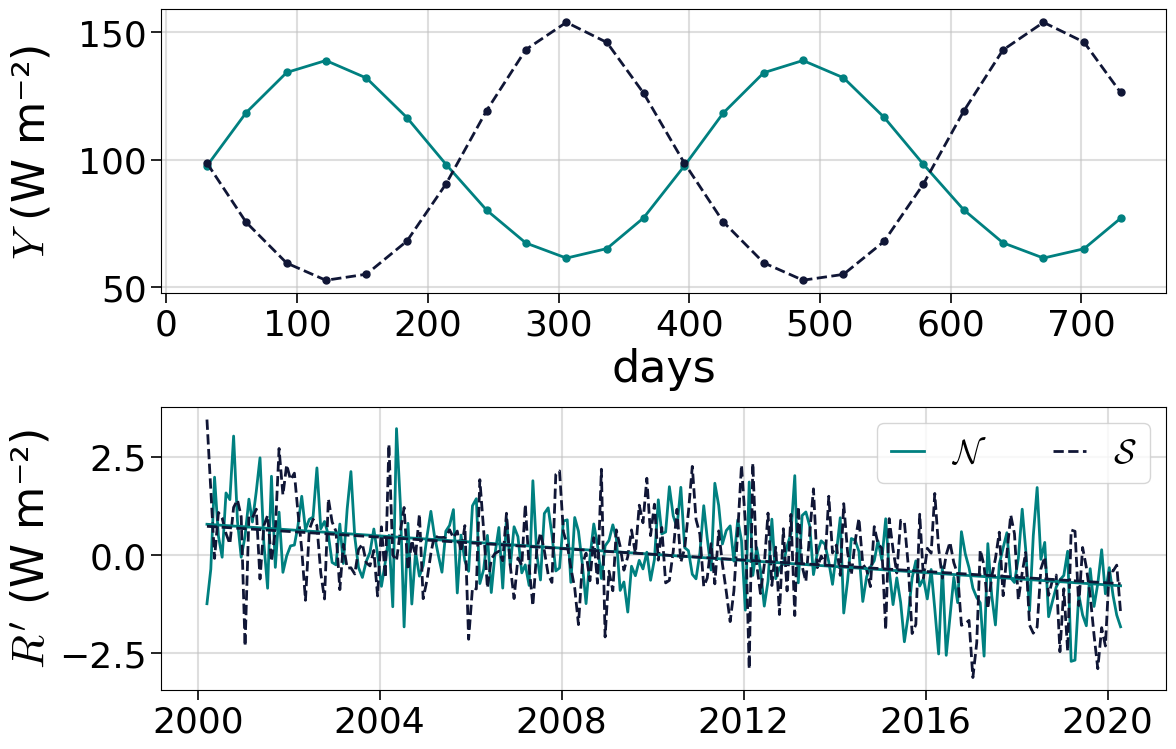

In [14]:
fig, axs = subplots(2, 1; figsize = (figx, 8))

sinusoidal = Sinusoidal(Float32.([1, 2] ./ DAYS_IN_ORBIT))
Rn_sea, Rn_res = decompose(Rn, sinusoidal)
Rs_sea, Rs_res = decompose(Rs, sinusoidal)

seasonals = (Rn_sea, Rs_sea)
residuals = (Rn_res, Rs_res)

n, s = seasonals
g = (n .+ s) ./ 2
axs[1].plot(truetime[1:24], n[1:24], label = "\$\\mathcal{N}\$", marker = "o", ms = 5)
axs[1].plot(truetime[1:24], s[1:24]; ls = "--", label = "\$\\mathcal{S}\$", marker = "o", ms = 5)
axs[1].set_xlabel("days")

n, s = residuals
g = (n .+ s) ./ 2
axs[2].plot(t, n, label = "\$\\mathcal{N}\$")
axs[2].plot(t, s; ls = "--", label = "\$\\mathcal{S}\$")
axs[2].legend(loc="upper right", ncol = 3)
sn, = plottrend!(axs[2], t, n; color = "C0", addlabel=false)
ss, = plottrend!(axs[2], t, s; color = "C1", addlabel=false, ls = "dashed")

axs[1].set_ylabel("\$Y\$ (W m⁻²)")
axs[2].set_ylabel("\$R'\$ (W m⁻²)")
fig.tight_layout()
fig.align_ylabels(axs)
fig.subplots_adjust(hspace = 0.4, left = 0.13, bottom = 0.1)

Slopes of residuals

In [15]:
sn, ss

(-0.006483486413988496, -0.006052388549005674)

Percentage of variance of R that is due to seasonal components:

In [16]:
var(Rn_sea)/var(Rn), var(Rs_sea)/var(Rs)

(0.9986366366881088, 0.9990573698601449)

Percentage of variance of R that is due to residual components:

In [17]:
var(Rn_res)/var(Rn), var(Rs_res)/var(Rs)

(0.0013632567776762233, 0.000942693041685349)

Percentage of variance of R that is due to covariability of seasonal-residual

In [18]:
cov(Rn_sea, Rn_res)/var(Rn), cov(Rs_sea, Rs_res)/var(Rs)

(3.0731893761551424e-8, 4.056178959427072e-8)

## Residuals are noise

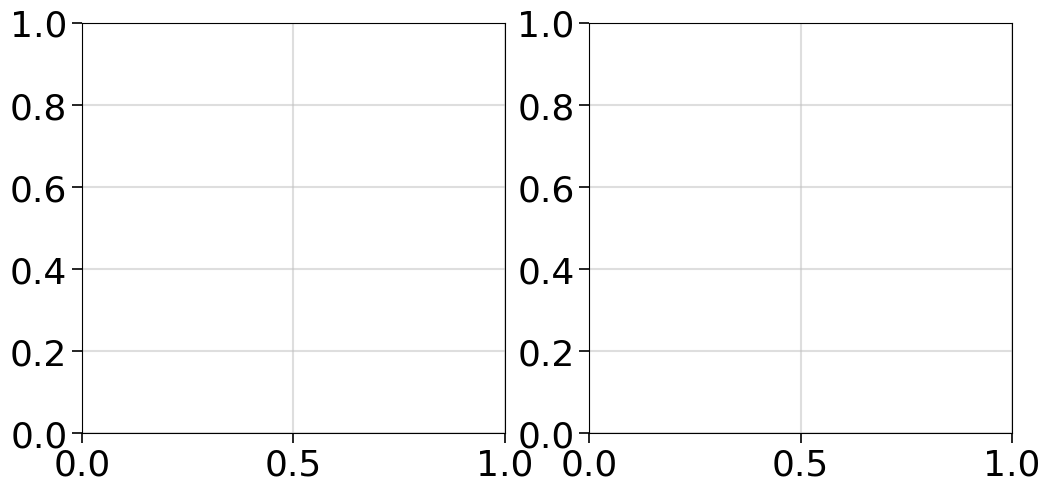

242-element Vector{Float64}:
 -1.2380298919515127
 -0.3583075393302835
  1.977958910515241
  0.4830030696542451
 -0.056728704474437563
  1.5773341865603925
  1.408360240239844
  3.02262996138532
  0.8629306324722421
 -0.055794545205287704
  0.47976053196403257
  1.420405665490847
  0.8392564425349747
  ⋮
 -1.00401124912284
 -1.5238372202987023
 -1.7980016211497514
 -0.3477636266107851
 -1.3070175724821667
 -0.7247727489273927
  0.13398407410268476
 -0.9862962000521662
 -0.321467891493171
 -1.0386598167815038
 -1.5257074428723598
 -1.8240089997978686

In [19]:
using Random, TimeseriesSurrogates, Distributions
fig = figure(figsize = (figx, 2figy/3))

ax_gaus = fig.add_subplot(1,2,1)
ax_mi = fig.add_subplot(1,2,2)

x = Rn_res # change to Rs_res for SH

detrend before plotting distribution

In [20]:
_, _, trend = linreg(1:length(x), x)
xdet = x .- trend

242-element Vector{Float64}:
 -2.0192965116479558
 -1.1330906726127379
  1.2096592636467753
 -0.2788130908002323
 -0.8120613785149264
  0.828484998933892
  0.6659945390273322
  2.2867477465867965
  0.1335319040877072
 -0.7787097871758342
 -0.23667122359252535
  0.7104573963482775
  0.13579165980639374
  ⋮
 -0.2940759936019286
 -0.8074184783638025
 -1.075099392800863
  0.38162208815209175
 -0.5711483713053014
  0.01757993866346097
  0.8828202481075271
 -0.23097653963333542
  0.44033525533964823
 -0.2703731835346961
 -0.7509373232115635
 -1.0427553937230838

fit normal distribution

In [21]:
gaussian = Distributions.fit(Normal, xdet)

Normal{Float64}(μ=8.074349270001139e-17, σ=0.9017155206473435)

q-q plot

In [22]:
q1 = quantile.(Ref(xdet), 0:0.01:1)
q2 = quantile.(gaussian, 0:0.01:1)
ax_gaus.plot(q1, q2; marker = "o", ls = "none")
ax_gaus.plot(-3:3, -3:3; lw = 1, color = "C1")
ax_gaus.set_xlim(-3, 3)
ax_gaus.set_ylim(-3, 3)
ax_gaus.set_xlabel("quantile res.")
ax_gaus.set_ylabel("quantile G.")

PyObject Text(4.444444444444459, 0.5, 'quantile G.')

### Calculate mutual information

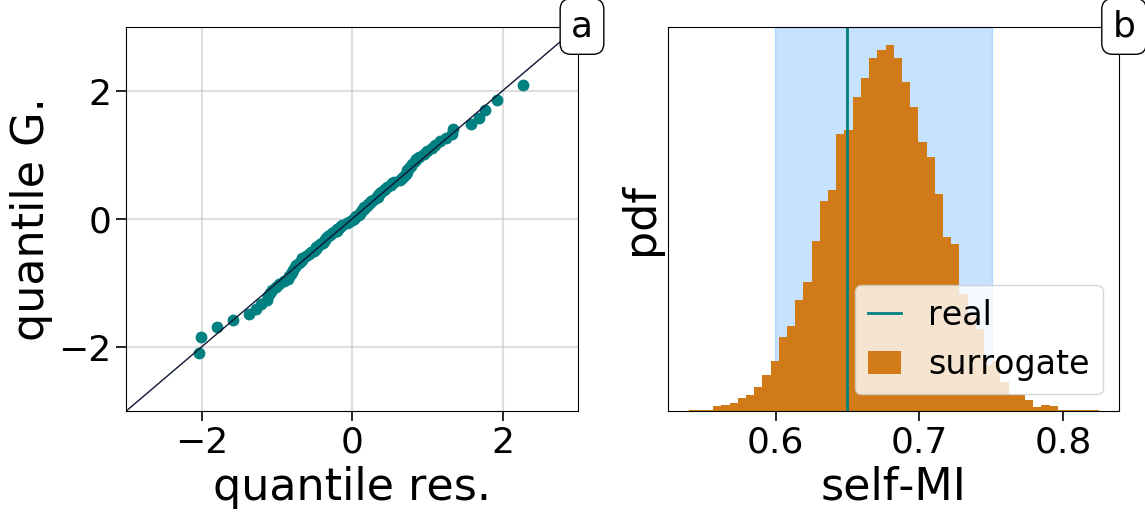

In [23]:
using Entropies
sg = surrogenerator(x, TFTS(0.1))

x = Array(Rn_res)[1:end-1]
y = Array(Rn_res)[2:end]
function mutualinfo(x, y, ε)
    Hx = genentropy(Dataset(x), ε)
    Hy = genentropy(Dataset(y), ε)
    Hxy = genentropy(Dataset(x,y), ε)
    return Hx + Hy - Hxy
end
bins = std(x)/4 # bins used for MI
mi = mutualinfo(x, y, bins)
M = 10000;
mis = zeros(M)

for i in 1:M
    local s = sg()
    local x = s[1:end-1]
    local y = s[2:end]
    mis[i] = mutualinfo(x, y, bins)
end

μ, σ = meanstd(mis)
ax_mi.axvspan(μ-2σ, μ+2σ, color = "C2", alpha = 0.25)
ax_mi.hist(mis, 50, color = "C3", density = true, label = "surrogate")
ax_mi.set_yticks([])
ax_mi.grid(false)
ax_mi.axvline(mi, color = "C0", label = "real")
ax_mi.legend(loc = "lower right")
ax_mi.set_xlabel("self-MI")
ax_mi.set_ylabel("pdf")

fig.tight_layout()
add_identifiers!(fig)
fig.subplots_adjust(wspace = 0.2, hspace = 0.3, left = 0.14, bottom = 0.2, top =0.92)
fig

## Distributions for ΔR values

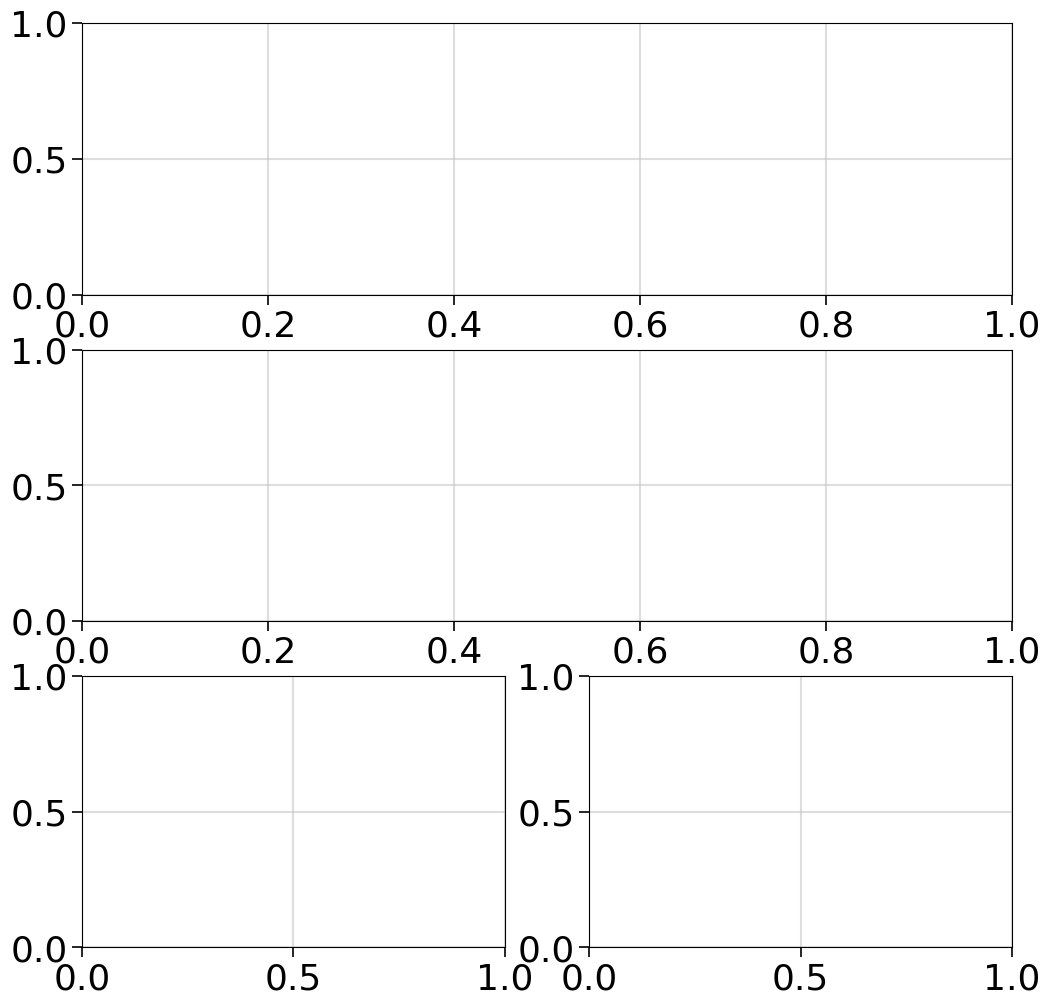

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x00000000BEB47EF0>

In [24]:
using TimeseriesSurrogates, Random
fig = figure(;figsize = (figx, 3figy/2))
ax_pps = fig.add_subplot(3,1,1)
ax_ar = fig.add_subplot(3,1,2; sharex = ax_pps)
ax_difpps = fig.add_subplot(3,2,5)
ax_difar = fig.add_subplot(3,2,6)

### Pseudoperiodic surrogates

In [25]:
τ = 3 # delay time = when AC becomes zero
ρ = 0.5 # evaluated using `noiseradius` function
d = 3 # embedding dimension
pp = PseudoPeriodic(d, τ, ρ, false)
sgnh = surrogenerator(Array(Rn), pp)
sgsh = surrogenerator(Array(Rs), pp)

Random.seed!(5151525)
ax_pps.plot(t, Rn, label = "\$\\mathcal{N}(R)\$", marker = "o", ms = 4)
ax_pps.plot(t, sgnh(), color = "C3", ls = "dashed", label = "surrogate", marker = "o", ms = 4)
ax_pps.legend(ncol=2)
ax_pps.set_ylabel("W m⁻²")

M = 5000
differences = zeros(M)
for i in 1:M
    rnh = sgnh()
    rsh = sgsh()
    differences[i] = timeagg(mean, t, rnh .- rsh)
end

μ, σ = meanstd(differences)
ax_difpps.axvspan(μ-2σ, μ+2σ, color = "C2", alpha = 0.25)
ax_difpps.hist(differences, 50, color = "C3", density = true, label = "surrogate")
ax_difpps.axvline(timemean(Rn .- Rs), color = "C0", label = "real")
ax_difpps.set_yticks([])
ax_difpps.grid(false)
ax_difpps.set_xticks(-0.25:0.25:0.25)
ax_difpps.set_ylabel("pdf")
ax_difpps.set_xlabel("avg. diff. \$\\Delta R\$ (W m⁻²)")
ax_difpps.legend(loc = "lower left")

PyObject <matplotlib.legend.Legend object at 0x0000000000F221D0>

### Autoregressive approximation

In [26]:
using StatsBase, ARFIMA, DSP, Random

D = Rn_res .- Rs_res
n = length(D)
σ = std(D)

1.5476213420957226

Now we estimate the parameters for the autoregressive process.
There are several ways to do it. One can use the Yule-Walker equations, or
hyper-optimization on a predefined length of parameters `p`. Here we will use
linear predictive code estimation.

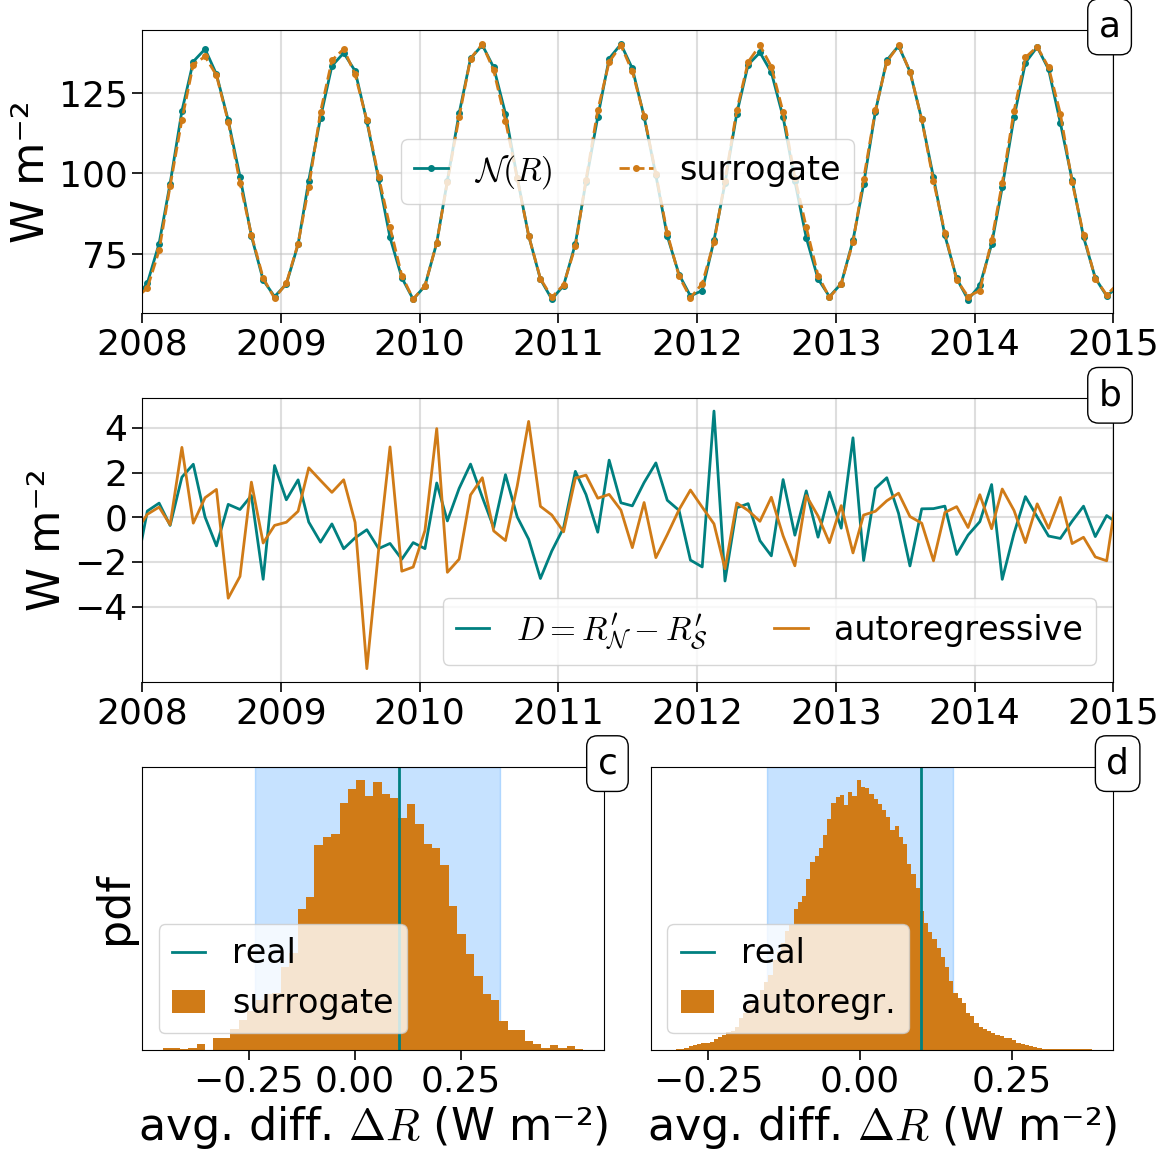

In [27]:
lpcmethod = DSP.LPCLevinson()
φ, e = DSP.lpc(D, 12, lpcmethod)
φ = -SVector(φ...) # definition of `φ` in ARFIMA is with -

rng = Random.MersenneTwister(612354152) # reproducibility
X = arma(rng, n+length(φ), σ, φ)[length(φ)+1:end]

ax_ar.plot(t, D, label = "\$D = R_\\mathcal{N}' - R_\\mathcal{S}'\$")
ax_ar.plot(t, X, label = "autoregressive", color = "C3")
ax_ar.set_xlim(tspan...)
ax_ar.legend(loc = "lower right", ncol = 2)
ax_ar.set_ylabel("W m⁻²")
ax_ar.set_yticks(-4:2:4)

N = 100000
X = arma(N, σ, φ) # simulate ultra long AR process
X .-= mean(X) # assert mean 0 for clarity
possible = Float64[]
for i in n:N-n
    push!(possible, mean(view(X, i:i+n)))
end
q1 = quantile(possible, 0.05)
q2 = quantile(possible, 0.95)
ax_difar.axvspan(q1, q2, color = "C2", alpha = 0.25)
ax_difar.hist(possible, color = "C3", 100, label = "autoregr.")
ax_difar.axvline(0.1, color = "C0", label = "real")
ax_difar.legend(loc="lower left")
ax_difar.set_yticks([])
ax_difar.set_xticks(-0.25:0.25:0.25)
ax_difar.grid(false)
ax_difar.set_xlabel("avg. diff. \$\\Delta R\$ (W m⁻²)")

fig.tight_layout()
fig.subplots_adjust(wspace = 0.1, hspace = 0.3, left = 0.12, bottom = 0.1, top =0.95)
add_identifiers!(fig)
fig

## Mean albedo decomposition + Fourier (only R)

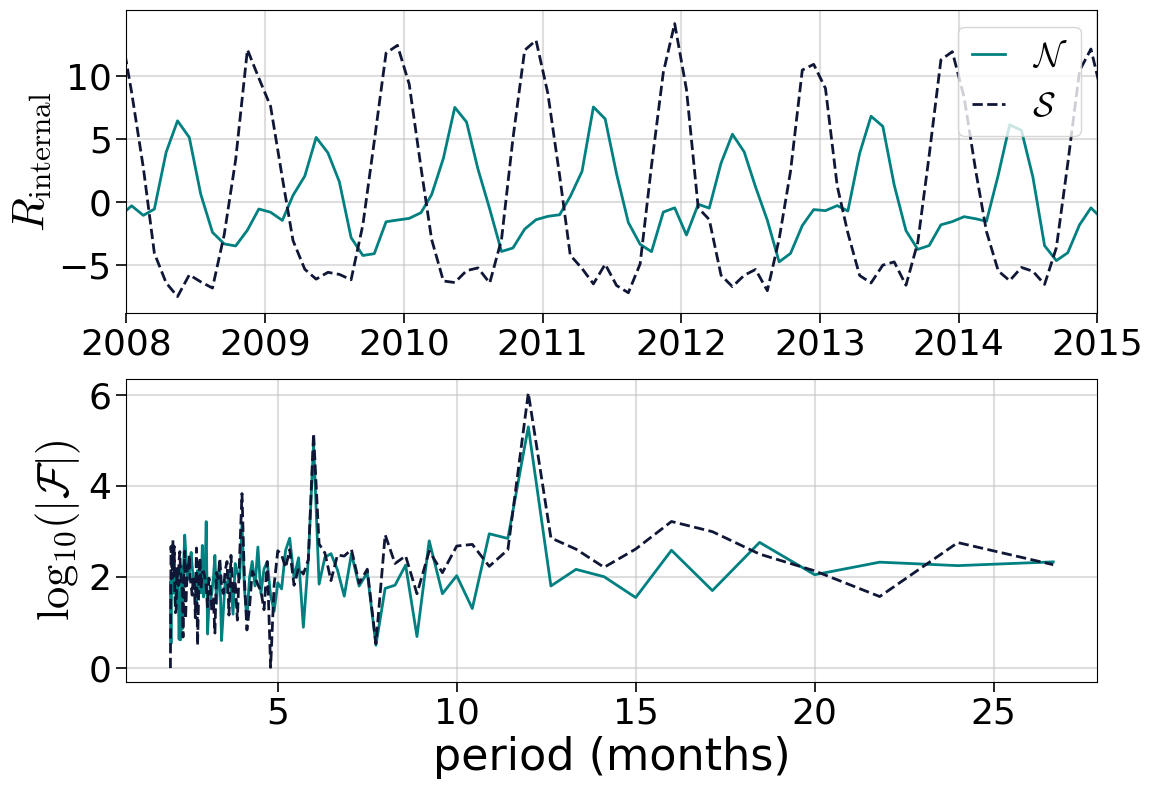

Percentage of variance of internal for toa_sw_all_mon
(in, is) = (0.014512852142708758, 0.03442368208743091)
Percentage of variance of covariability with sun for toa_sw_all_mon
(cn, cs) = (0.13684271143822854, 0.28369635364030976)
Percentage of variance of covariability with sun for toa_sw_all_mon
(sn, ss) = (0.8486443913486353, 0.6818801082976687)



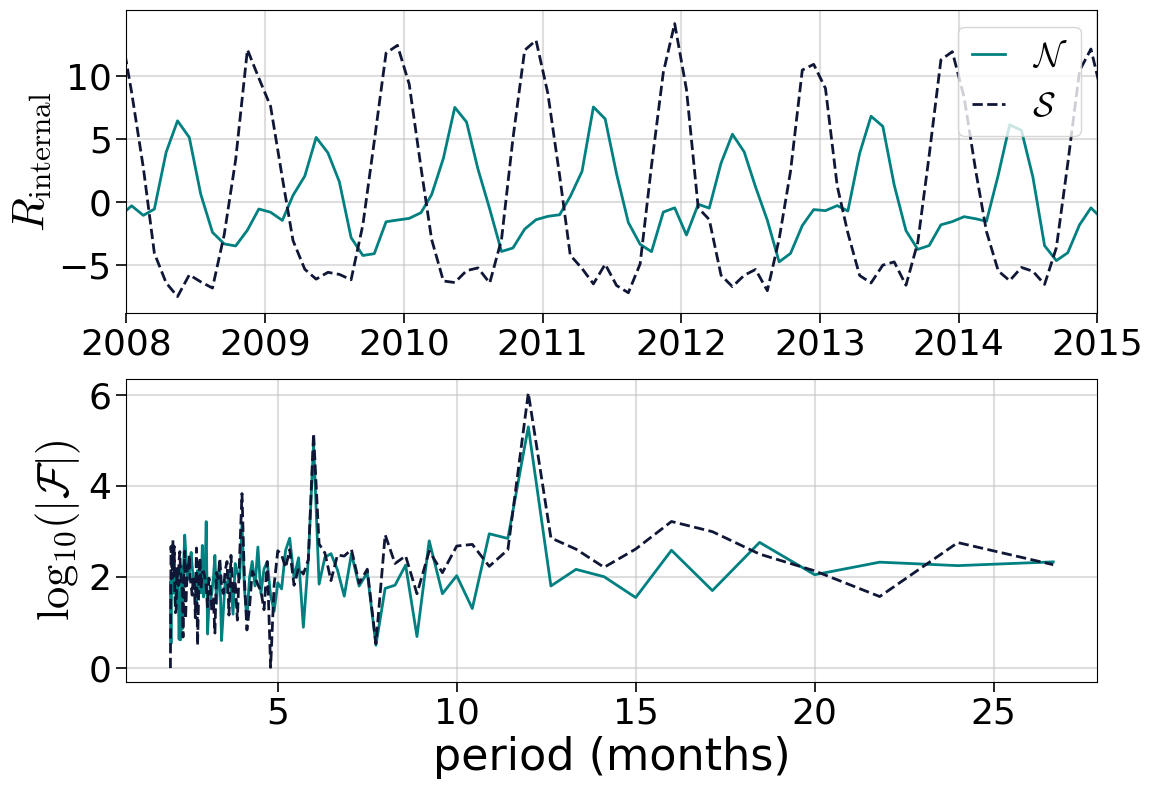

In [28]:
fig, axs = subplots(2,1)

i = 1; X = R
Xn, Xs = hemispheric_means(zonalmean(X))
solarn, internaln = decompose(t, Xn.data, MeanAlbedo(Ιn.data))
solars, internals = decompose(t, Xs.data, MeanAlbedo(Is.data))

αn = timemean(Rn)/timemean(Ιn)
αs = timemean(Rs)/timemean(Is)

axs[i].plot(t, internaln, label = "\$\\mathcal{N}\$")
axs[i].plot(t, internals; ls = "--", label = "\$\\mathcal{S}\$")

in, is = var(internaln)/var(Xn), var(internals)/var(Xs)
println("Percentage of variance of internal for $(X.name)")
@show in, is

cn, cs = 2cov(solarn, internaln)/var(Xn), 2cov(solars, internals)/var(Xs)
println("Percentage of variance of covariability with sun for $(X.name)")
@show cn, cs

sn, ss = var(solarn)/var(Xn), var(solars)/var(Xs)
println("Percentage of variance of covariability with sun for $(X.name)")
@show sn, ss
println()

axs[1].legend(loc="upper right"; ncol=1)
axs[1].set_ylabel("\$R_\\mathrm{internal}\$")
axs[1].set_yticks(-5:5:10)
axs[1].set_xlim(Date(2008), Date(2015))

method = :FFTW
for (j, r) in enumerate((internaln[1:mys], internals[1:mys]))
    # This can be made into Lomb-Scargle periodogram for more accuracy
    # since the time axis is non-equi-spaced.
    if method == :FFTW
        P = abs2.(rfft(r .- mean(r)))
        f = FFTW.rfftfreq(length(r))
        ps = 1 ./ Float64.(f)
    elseif method == :LombScargle
        truetime = daysinmonth.(t[1:mys])
        truetime = Float32.(cumsum(truetime))
        periodogram = lombscargle(truetime, Array(r))
        ps, P = periodpower(periodogram)
        ps ./= 30 # divide by number of days in month (approx.)
    end
    spi = sortperm(ps)
    ps = ps[spi]; P = P[spi]
    # Limit periods shown to `maxmonth`
    maxmonth = 2*12 + 2
    ℓ, k = findnearest.((2, maxmonth), Ref(ps))
    ps = ps[ℓ:k]
    P = P[ℓ:k]
    P = abs.(P)
    axs[2].plot(ps, log10.(P),
    color = "C$(j-1)", ls = j == 1 ? "-" : "--")
end

axs[2].set_ylabel("\$\\log_{10}(|\\mathcal{F}|)\$")
axs[2].set_xlabel("period (months)")

fig.tight_layout()
fig.subplots_adjust(left = 0.12, bottom = 0.12, hspace=0.22, top = 0.96)
fig

## Longitude split (quadrant of hemisphere)

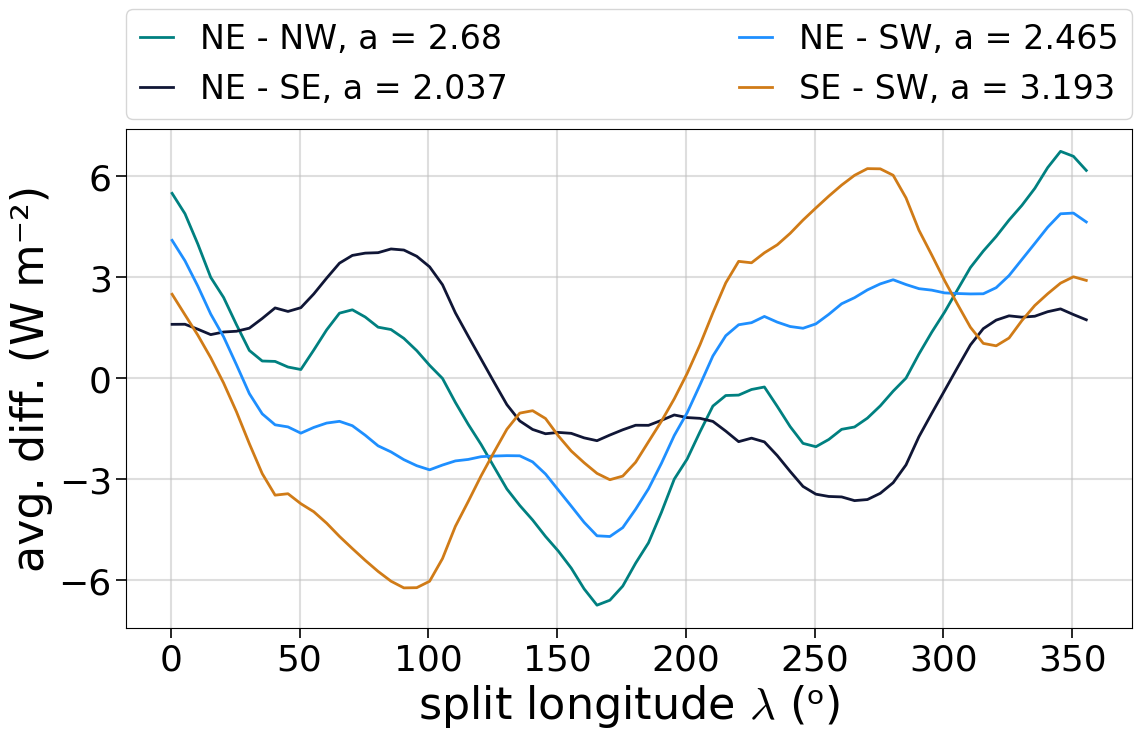

In [29]:
λs = dims(R, Lon)[1:5:size(R, Lon)]
d = zeros(length(λs), 4)
X, Y = hemispheric_functions(R)
for (i, λ) in enumerate(λs)
    X1, X2 = split_at_longitude(X, λ)
    Y1, Y2 = split_at_longitude(Y, λ)
    NE, NW = timemean.(spacemean.((X1, X2)))
    SE, SW = timemean.(spacemean.((Y1, Y2)))

    d[i, 1] = NE - NW
    d[i, 2] = NE - SE
    d[i, 3] = NE - SW
    d[i, 4] = SE - SW
end

fig = figure()
ax = gca()
for (i, n) in zip(1:4, ("NE - NW", "NE - SE", "NE - SW", "SE - SW", "NW - SW", "SE - SW"))
    z = d[:, i]
    a = mean(abs.(z))
    ax.plot(λs, z, label = "$(n), a = $(rdspl(a))")

end

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc="lower left",
          ncol=2, mode="expand", borderaxespad=0.)
ax.set_xlabel("split longitude \$\\lambda\$ (ᵒ)")
ax.set_ylabel("avg. diff. (W m⁻²)")
ax.set_yticks(-6:3:6)
fig.tight_layout()

# Cloudiness

## Definition and comparison

In [30]:
Tcorrected = sinusoidal_continuation(T, [1, 2.0]; Tmin = 0)
C1 = cloud_effective_albedo(F, Tcorrected, 0.9)
C1_timeavg = timemean(C1)

ClimArray (named effective cloud albedo, g = 0.9) with dimensions:
  Lon (Longitude): 0.5f0:1.0f0:359.5f0 (Sampled - Ordered Regular Points)
  Lat (Latitude): -89.5f0:1.0f0:89.5f0 (Sampled - Ordered Regular Points)
and data: 360×180 Matrix{Float64}
 0.202091  0.182979  0.172246  0.15727   …  0.138414  0.138223  0.136148
 0.202091  0.182979  0.172246  0.15727      0.138414  0.138223  0.136148
 0.202091  0.182979  0.172246  0.15727      0.138414  0.138223  0.136148
 0.202091  0.182979  0.172246  0.15727      0.138414  0.138223  0.136148
 0.202091  0.181731  0.171009  0.15536      0.139431  0.138785  0.136148
 0.202091  0.181731  0.171009  0.15536   …  0.139431  0.138785  0.136148
 0.202091  0.181731  0.171009  0.15536      0.139431  0.138785  0.136148
 0.202091  0.181731  0.171009  0.15536      0.139431  0.138785  0.136148
 ⋮                                       ⋱                      
 0.202091  0.185529  0.175951  0.164304     0.137457  0.137586  0.136148
 0.202091  0.185529  0.175951

use `\:arrow_down:` and tab for arrows

In [31]:
F_s_⬆ = ncread(EBAF_SFC, "sfc_sw_up_all_mon")
F_s_⬇ = ncread(EBAF_SFC, "sfc_sw_down_all_mon")
F_s_⬆_K = ncread(EBAF_SFC, "sfc_sw_up_clr_c_mon")
F_s_⬇_K = ncread(EBAF_SFC, "sfc_sw_down_clr_c_mon");

Because surface data do not have the same amount of points, we are forced to use a
smaller time span. (even if we time-average fields, this is still the accurate thing to do)

In [32]:
l = size(F_s_⬆, Time)
argsall = timemean.((I[Time(1:l)], R[Time(1:l)], F_s_⬆, F_s_⬇))
argsclr = timemean.((I[Time(1:l)], K[Time(1:l)], F_s_⬆_K, F_s_⬇_K))
α_ATM, α_SFC = surface_atmosphere_contributions(argsall...) # all sky
α_ATM_K, α_K_SFC = surface_atmosphere_contributions(argsclr...) # clear sky

C2_timeavg = α_ATM .- α_ATM_K

if false # plot spatial fields
    cmap = "gist_earth"
    as = (α_ATM, α_ATM_K, C2_timeavg, C1_timeavg, C1_timeavg .- C2_timeavg, α_ATM .+ α_SFC)
    nmes = ("α_ATM", "α_ATM_K", "C₂", "C₁", "C₁ - C₂", "α_TOA")
    kwargs = (vmin = 0, levels = 21, vmax = 0.7, cmap = "gist_earth")
    for (a, name) in zip(as, nmes)
        @show name, extrema(a)
        if name != "C₁ - C₂"
            fig, ax, = earthsurface(a; cmap = cmap, vmin = 0, vmax = 0.7)
        else
            fig, ax, = earthsurface(a; cmap = cmap, vmin = -0.2, vmax = 0.2)
        end
        ax.set_title(name)
    end
end

We now need to estimate `g` so that the two versions match in value.
Ιn the paper we call this the energetically consistent modification.

In [33]:
a = C2_timeavg; τ = timemean(Tcorrected); f = timemean(F)
_x = -2a ./ (τ .* a - f .* τ)
g = clamp.(1 .- _x ./ √3, 0, 1)

C = cloud_effective_albedo(F, Tcorrected, g)

ClimArray (named effective cloud albedo, g = array) with dimensions:
  Lon (Longitude): 0.5f0:1.0f0:359.5f0 (Sampled - Ordered Regular Points)
  Lat (Latitude): -89.5f0:1.0f0:89.5f0 (Sampled - Ordered Regular Points)
  Ti (Time): Date("2000-03-15"):Month(1):Date("2020-04-15") (Sampled - Ordered Regular Points)
and data: 360×180×242 Array{Float64, 3}
[:, :, 1]
 0.0824704  0.0501025  0.0461103  0.041947   …  0.262624  0.213068  0.225067
 0.0824655  0.0500968  0.0461056  0.0419424     0.262641  0.213086  0.225104
 0.0824736  0.0501041  0.0460989  0.0419364     0.262669  0.213024  0.225122
 0.0824849  0.050114   0.0460914  0.0419294     0.262701  0.212943  0.22514
 0.0824969  0.0500033  0.0423193  0.0382412     0.25737   0.218024  0.225153
 0.0825077  0.0500136  0.0423124  0.0382346  …  0.257337  0.217828  0.225161
 0.0825179  0.0500208  0.0423062  0.0382287     0.257218  0.217848  0.225029
 ⋮                                           ⋱                      
 0.0822576  0.0494986  0.045312

Let's produce maps of f, τ, g, C (for appendix)

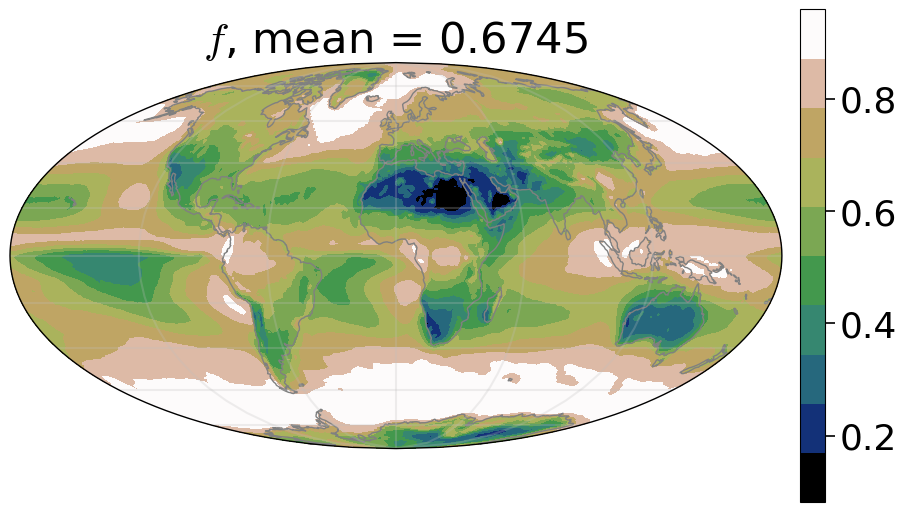

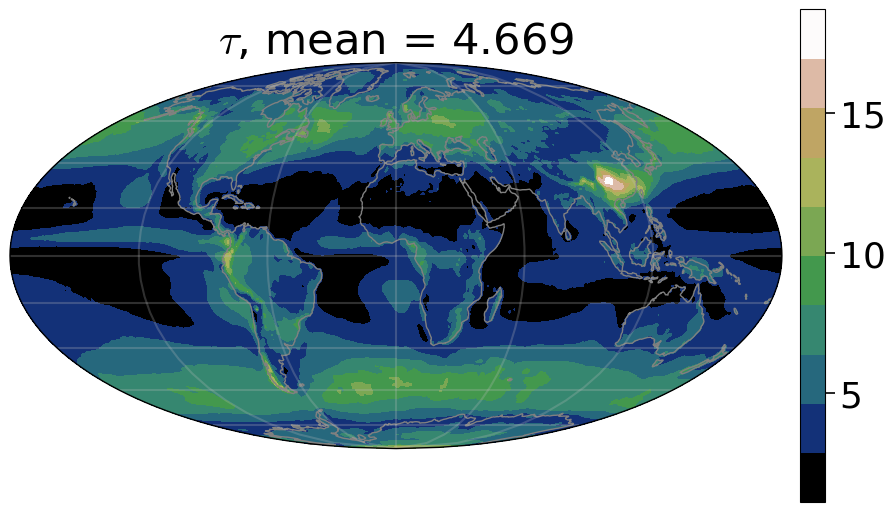

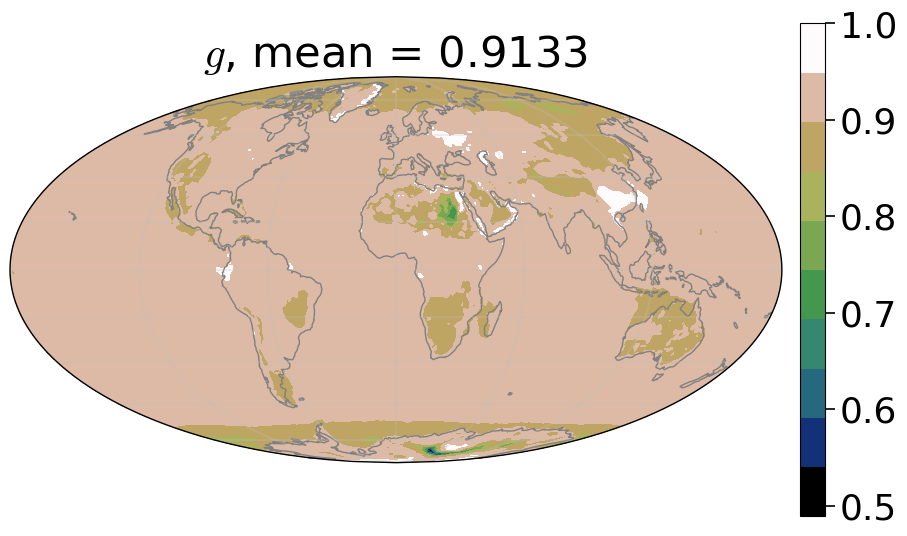

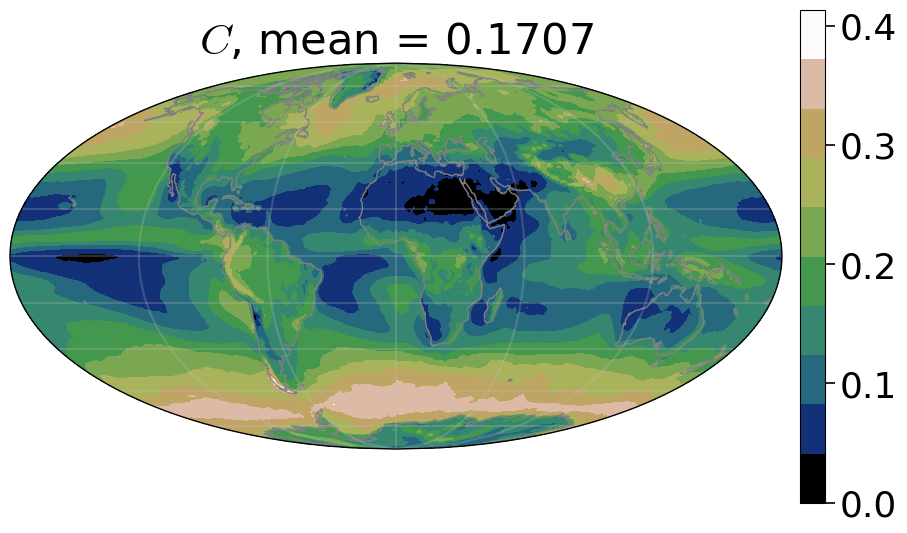

In [34]:
for (label, X) in zip(("f", "\\tau", "g", "C"), (f, τ, g, timemean(C)))
    m = spacemean(X)
    fig, ax, = earthsurface(X; cmap = "gist_earth")
    ax.set_title("\$$(label)\$, mean = $(rdspl(m))")
end

Average cloud albedo per hemisphere:

In [35]:
Cn, Cs = hemispheric_means(C)
timemean.((Cn, Cs))

(0.16039076842150715, 0.1809961758798077)

## Plot of zonally average cloudiness, along with average values

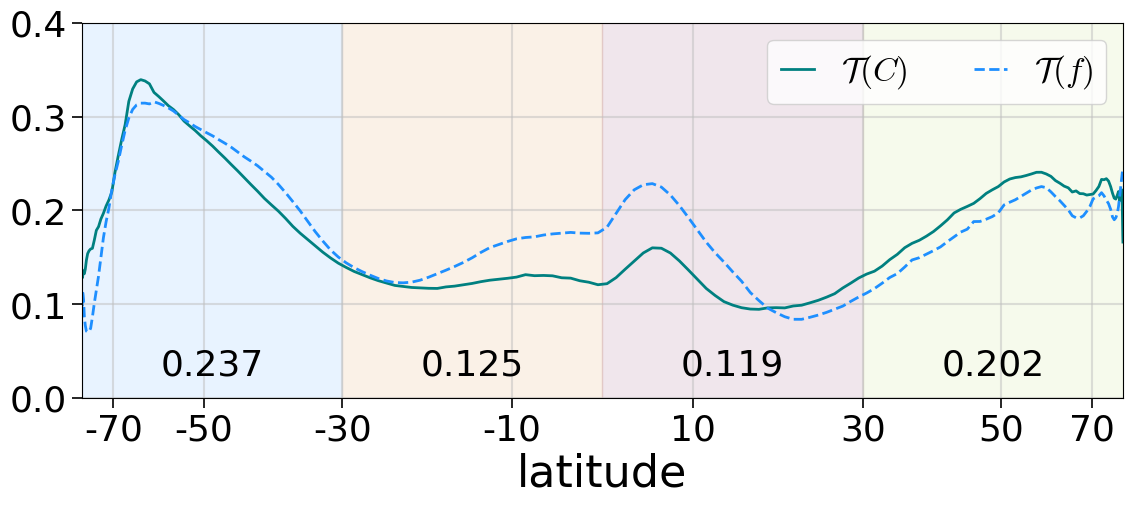

In [36]:
fig = figure(figsize = (figx, 5))
Cz = timemean(zonalmean(C))
ax = gca()
ax.plot(sind.(dims(Cz, Lat)), Cz, label = "\$\\mathcal{T}(C)\$")
Fz = timemean(zonalmean(F))
Fz = (Fz .- mean(Fz)) ./ std(Fz)
Fz = Fz .* std(Cz) .+ mean(Cz)
ax.plot(sind.(dims(Cz, Lat)), Fz, ls = "dashed", color = "C2", label = "\$\\mathcal{T}(f)\$")
ax.legend(ncol = 2)

lats = dims(Cz, Lat) |> Array

latr = [-90, -30, 0, 30, 90]
s = 0.0
for i in 1:4
    l1, l2 = latr[i], latr[i+1]
    mv = latmean(Cz[Lat(Between(l1, l2))])
    x = (sind(l1) + sind(l2))/2
    ax.text(x, 0.025, rdspl(mv, 3), ha = :center)
    global s += mv
    ax.axvspan(sind(l1), sind(l2); alpha = 0.1, color = "C$(i+1)")
end
ax.set_ylim(0, 0.4)
llats = -70:20:70
ax.set_xticks(sind.(llats))
ax.set_xticklabels(llats)
ax.set_xlim(-1,1)
ax.set_xlabel("latitude");

fig.tight_layout()
fig.subplots_adjust(left = 0.1, bottom = 0.2, top = 0.95)

## Plot of cloudiness timeseries and correlation with solar cycle

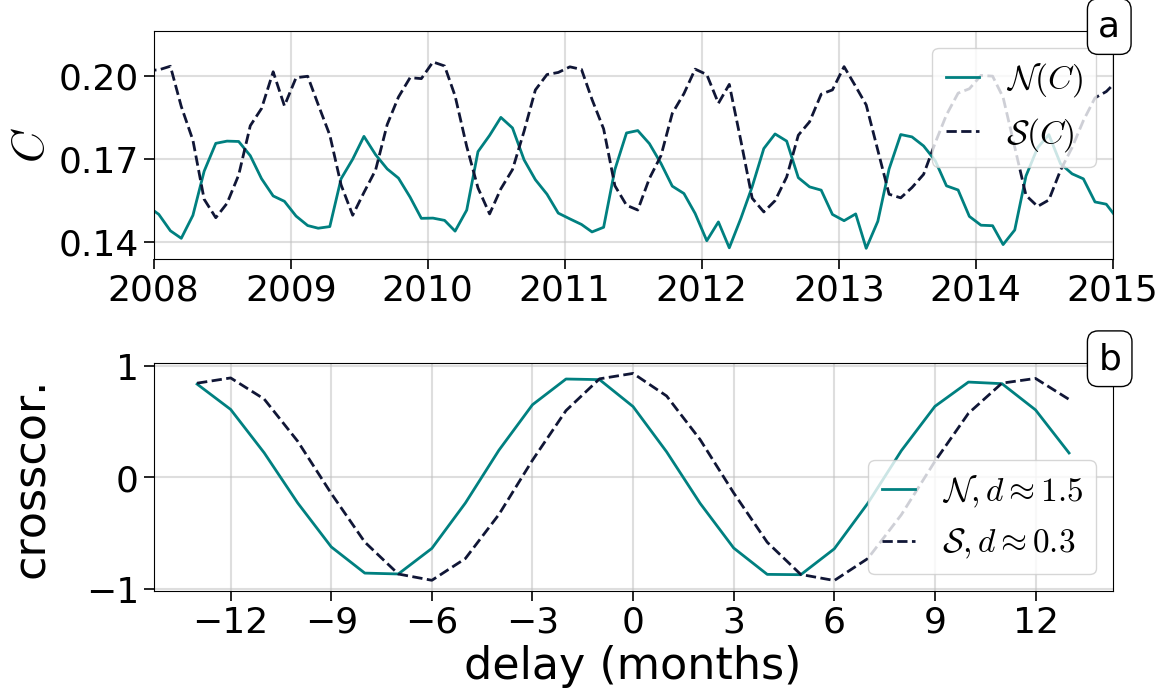

In [37]:
fig, axs = subplots(2,1; figsize = (figx, 7))
ax = axs[1]
ax.plot(t, Cn, label = "\$\\mathcal{N}(C)\$")
ax.plot(t, Cs; ls = "dashed", label = "\$\\mathcal{S}(C)\$")
ax.legend(loc = "upper right")
ax.set_yticks(0.14:0.03:0.20)
ax.set_xlim(tspan...)
ax.set_ylabel("\$C\$")

Cx = (Cn, Cs)
Ix = (Ιn, Is)
ax = axs[2]
lags = -13:13

monthlpv = Sinusoidal([1/12])
for j in 1:2
    cc = crosscor(Cx[j], Ix[j], lags)
    decompose(float.(lags), cc, monthlpv)
    φ = mod2pi(monthlpv.φ[2])
    φ = 12φ/2π # in months
    ax.plot(lags, cc, ls = j==1 ? "-" : "--",
    label="\$\\mathcal{$(j==1 ? "N" : "S")}, d \\approx $(rdspl(φ, 2))\$")
end
ax.set_xlabel("delay (months)"); ax.set_xticks(-12:3:12);
ax.legend(loc = "lower right")
ax.set_ylabel("crosscor.")

fig.tight_layout()
fig.subplots_adjust(left = 0.13, bottom = 0.15, top = 0.95)
add_identifiers!(fig)
fig.align_ylabels()

Weighted integrals of sunlight and cloudiness

In [38]:
D_with_sun = timeagg(mean, Cs, Is) - timeagg(mean, Cn, Ιn)
G_with_sun = 0.5(timeagg(mean, Cs, Is) + timeagg(mean, Cn, Ιn))
P_with_sun = 100 * D_with_sun/G_with_sun # proportion in percentage

D_no_sun = timeagg(mean, Cs) - timeagg(mean, Cn)
G_no_sun = 0.5(timeagg(mean, Cs) + timeagg(mean, Cn))
P_no_sun = 100 * D_no_sun/G_no_sun # proportion in percentage

P_with_sun, P_no_sun

(13.493824552570437, 12.071584928633834)

Alright, we now quantify the extra reflection one gets from the time delay
by shifting the NH timeseries until to matches the sun.

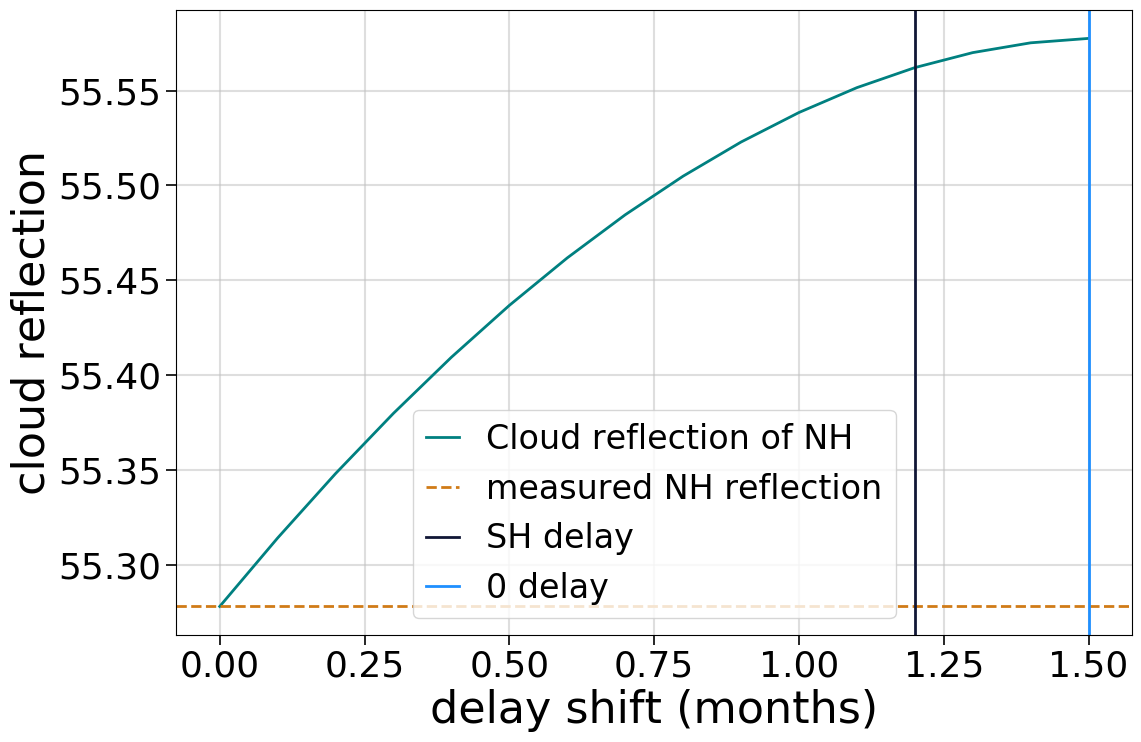

In [39]:
using Interpolations
cloud_reflection_n = timemean(Cn .* Ιn)
cloud_reflection_s = timemean(Cs .* Is)
t = dims(Ιn, Time) |> Array
interp = CubicSplineInterpolation(1:length(t), Cn.data; extrapolation_bc = Line())

result = []
ds = 0:0.1:1.5
for d in ds
    r = timemean([interp(i) for i in (1:length(t)) .+ d] .* Ιn)
    push!(result, r)
end

fig = figure()
plot(ds, result, label = "Cloud reflection of NH")
axhline(cloud_reflection_n, ls = "dashed", label = "measured NH reflection", color = "C3")
axvline(1.2, color = "C1", label = "SH delay")
axvline(1.5, color = "C2", label = "0 delay")
ylabel("cloud reflection")
xlabel("delay shift (months)")
legend()
tight_layout()

The effect of shifting the timeseries of NH by 1.2 months (so that they have same
delay as SH) compensates the asymmetry by:

In [40]:
effect = result[13] - result[1]

0.28413695201715683

## Cloudiness over specific land type
Because `O, L, E` have a shorter timespan than `C`, we need to modify `C` to be
in the same time span.

In [41]:
function hemispheric_weighted_avgs(X, fields)
    @assert size(X) == size(fields[1])
    Xn, Xs = hemispheric_functions(X)
    Xnt, Xst = timemean.((Xn, Xs))
    northpie = []
    southpie = []
    northcov = []
    southcov = []

    for W in fields
        Wn, Ws = hemispheric_functions(W)
        Gn, Gs = spacemean(Xn, Wn), spacemean(Xs, Ws)
        Gna, Gsa = timemean.((Gn, Gs))
        Wnt, Wst = timemean.((Wn, Ws))
        push!(northpie, (Gna, spacemean(Wnt)))
        push!(southpie, (Gsa, spacemean(Wst)))
        # calcualte no covariability
        push!(northcov, spacemean(Xnt, Wnt))
        push!(southcov, spacemean(Xst, Wst))
    end
    return northpie, southpie, northcov, southcov
end

ol = size(O, Time)
northpie, southpie, northcov, southcov = hemispheric_weighted_avgs(C[Time(1:ol)], (O, E, L));

Put the numbers into bar plot

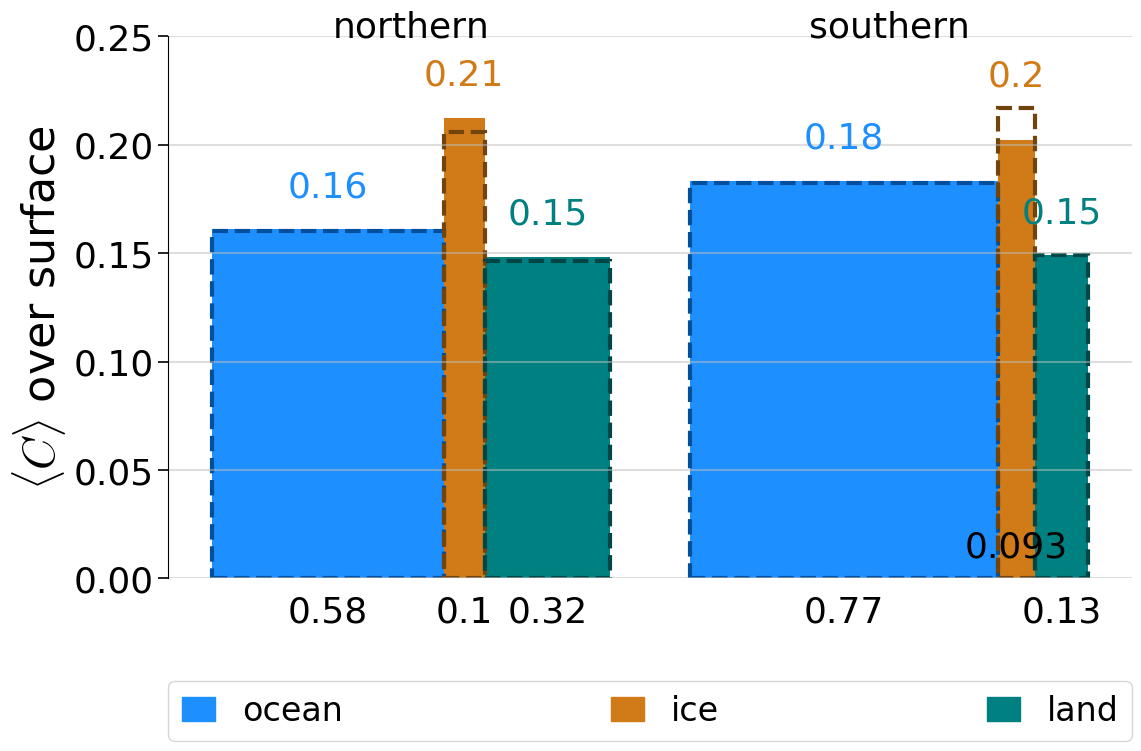

In [42]:
fig = figure()
ax = fig.add_subplot()
colors = ["C2", "C3", "C0"]
fig.tight_layout()
prefix = 1.2

for (i, data) in enumerate((northpie, southpie))
    pre = i == 1 ? 0.0 : prefix
    widths = [s[2] for s in data]
    x = [0, cumsum(widths)[1:end-1]...] .+ pre
    h = [s[1] for s in data]
    hcov = (northcov, southcov)[i]

    ax.bar(x, h; width = widths,
    color = colors, align = "edge")
    ax.bar(x, hcov; width = widths, linewidth = 3.0,
    color = colors, align = "edge", ls = "dashed", fill = false, edgecolor = lighten.(colors, 0.55))
    pos = x .+ widths./2
    for (j, (c, w)) in enumerate(data)
        str = "$(rdspl(c, 2))\n$(rdspl(w, 2))"
        off = + 0.015
        i == 2 && j == 2 && (off += 0.01)
        ax.text(pos[j], h[j] + off, string(rdspl(c, 2)), ha = :center, color = colors[j])
        botoff = (i == 2 && j == 2) ? +0.01 : -0.02
        ax.text(pos[j], botoff, string(rdspl(w, 2)), ha = :center)
    end
end
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.set_xticks([])
ax.spines["bottom"].set_visible(false)

ax.set_ylim(0, 0.25)
ax.set_ylabel("\$\\langle C \\rangle\$ over surface")
ax.text(0.5, 0.25, "northern", ha = :center)
ax.text(0.5 + prefix, 0.25, "southern", ha = :center)
fig.tight_layout()

# Create legend
mpatches = matplotlib.patches
handles = [mpatches.Patch(color=c, label=F) for (c, F) in zip(colors, (:ocean, :ice, :land))]

ax.legend(handles=handles; ncol=3, bbox_to_anchor=(0.0, -0.3, 1, .102), loc="lower left",
            mode="expand", borderaxespad=0.)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.24)

## Total albedo given surface and cloud albedo and transmittance
Main goal here is to see impact of having cloud albedo difference of `0.02`.

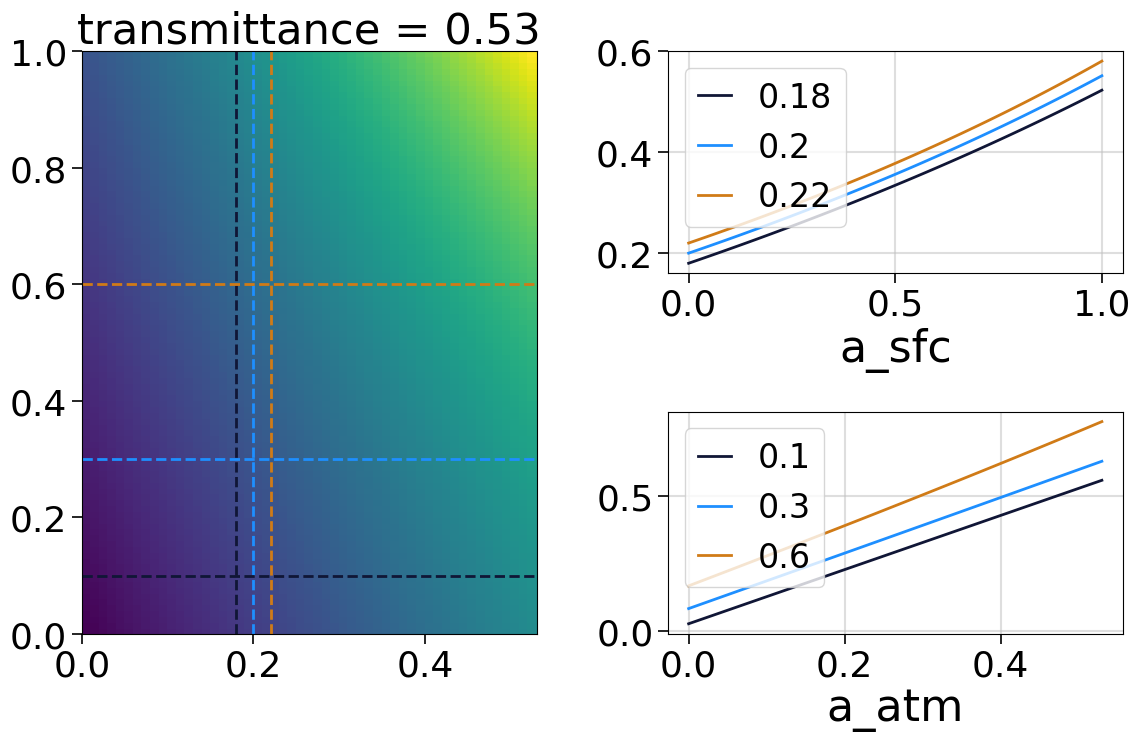

In [43]:
transmitance = 0.53 # some given trasmittance

asfc = 0:0.01:1.0
aatm = 0:0.01:transmitance

achoice = [0.18, 0.2, 0.22]
schoice = [0.1, 0.3, 0.6]

fig = figure()
ax1 = fig.add_subplot(1, 2, 1)
atoa = total_toa_albedo.(aatm, asfc', transmitance)
ax1.pcolormesh(aatm, asfc, atoa')
ax1.set_title("transmittance = $(transmitance)")
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 4)

for i in 1:length(achoice)
    a = achoice[i]
    ax1.axvline(a, color = "C$i", ls = "dashed")
    atotal = total_toa_albedo.(a, asfc, transmitance)
    ax2.plot(asfc, atotal, color = "C$i", label = "$(a)")
    ax2.set_xlabel("a_sfc")
    ax2.legend()
end

for i in 1:length(schoice)
    a = schoice[i]
    ax1.axhline(a, color = "C$i", ls = "dashed")
    atotal = total_toa_albedo.(aatm, a, transmitance)
    ax3.plot(aatm, atotal, color = "C$i", label = "$a")
    ax3.set_xlabel("a_atm")
    ax3.legend()
end

fig.tight_layout()

So for a broad range of values (and you have to zoom into the figure), we find a
total change of 0.02. This is also the surface abledo assymetry

In [44]:
Kn, Ks = hemispheric_means(K)
δαK = timemean(Kn ./ Ιn) - timemean(Ks ./ Is)

0.020196913526451477

# Appendices
## Continuation of value of τ

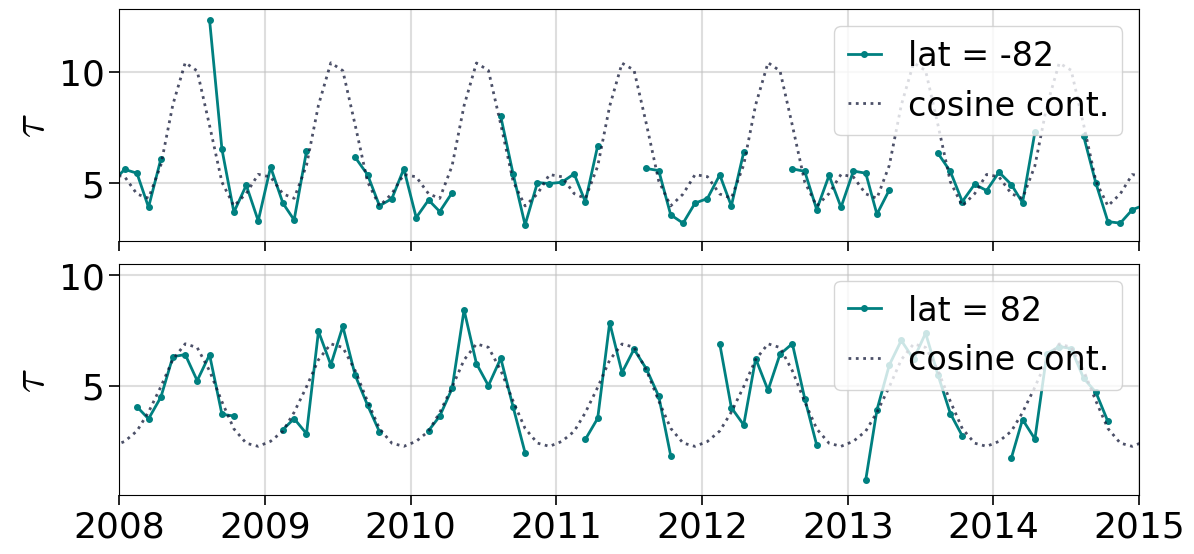

In [45]:
count(ismissing, T)/length(T) # about 6% of the points are missing

fig, axs = subplots(2, 1; figsize = (figx, 6), sharex = true)
for (i, l) in enumerate((-82, 82))
    ax = axs[i]
    example = T[Lat(Near(l)), Lon(Near(5))]
    example = Vector{Any}(Array(example))

    lpv = Sinusoidal(Float32.([1, 2] ./ DAYS_IN_ORBIT))
    nmi = findall(!ismissing, example)
    mi = findall(ismissing, example)
    x0 = Array{Float32}(example[nmi])
    t0 = truetime[nmi]
    sea, res = decompose(t0, x0, lpv)
    c = ClimateBase.cosines(truetime, lpv)
    acosine = copy(example)
    acosine[mi] .= c[mi]
    example[mi] .= nothing

    ax.plot(t, example, marker = "o", label = "lat = $(l)", ms = 4)
    ax.plot(t, c, ls = "dotted", alpha = 0.75, label = "cosine cont.")
    ax.legend(loc = "upper right")
    ax.set_ylabel("\$\\tau\$")
end
axs[2].set_xlim(tspan...)
fig.tight_layout()
fig.subplots_adjust(left = 0.1, right = 0.95, bottom = 0.14, hspace=0.1, top = 0.95)